In [1]:
import sys
import os

# Make the project root importable regardless of where Jupyter is launched from
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from matplotlib import pyplot as plt

from pnpflow.utils import load_cfg_from_cfg_file, define_model, load_model
from pnpflow.degradations import Denoising, RandomInpainting
import pnpflow.utils as utils

/home/pourya/miniconda3/envs/flower/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/home/pourya/miniconda3/envs/flower/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ── Configuration ──────────────────────────────────────────────────────────────
ROOT    = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
dataset = 'celeba'

# Load and merge base config, dataset config, and method config
cfg = load_cfg_from_cfg_file(os.path.join(ROOT, 'config/main_config.yaml'))
cfg.update(load_cfg_from_cfg_file(os.path.join(ROOT, f'config/dataset_config/{dataset}.yaml')))

method_config_file = os.path.join(ROOT, f'config/method_config/{cfg.method}.yaml')
cfg.update(load_cfg_from_cfg_file(method_config_file))

method_cfg = load_cfg_from_cfg_file(method_config_file)
cfg.dict_cfg_method = {k: cfg[k] for k in method_cfg.keys()}

cfg.root = ROOT + '/'

In [3]:
# ── Device & Model Initialisation ─────────────────────────────────────────────
device = 'cuda:0'   # change to 'cpu' if no GPU is available
cfg.device = device

model, state = define_model(cfg)
print(f'Model initialised on {device}.')

Model initialised on cuda:0.


In [4]:
# ── Load Pre-trained Weights ───────────────────────────────────────────────────
model_path = os.path.join(ROOT, 'model', dataset, 'ot', 'model_final.pt')
load_model('ot', model, state, download=False,
           checkpoint_path=model_path, dataset=None, device=device)
model.eval()
model = model.to(device)
print('Weights loaded successfully.')

/home/pourya/Flower/pnpflow/utils.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Weights loaded successfully.


In [5]:
# ── Non-Isotropic Noise Model Setup ───────────────────────────────────────────
# We consider a spatially-varying Gaussian noise model where the centre
# 50%×50% region of the image has 4× higher noise std than the border:
#
#   y = x + n,   n ~ N(0, R)   with diagonal covariance map R:
#       R(i,j) = 16 σ²   if (i,j) is in the centre patch
#                   σ²   otherwise
#
# FLOWER handles this via the CG data-consistency step which uses R directly,
# so no modification to the prior (flow model) is needed.

dim_image   = 128
num_channels = 3
sigma_noise  = 0.2           # base noise std (border region has σ, centre has 4σ)

degradation = Denoising()    # identity-operator forward model  H = I
H  = degradation.H
Ht = degradation.H_adj

# Spatial binary mask: 1 in centre 50%×50% patch, 0 on border
mask1 = torch.zeros((1, num_channels, dim_image, dim_image), device=device)
mask1[:, :, dim_image // 4 : 3 * dim_image // 4,
            dim_image // 4 : 3 * dim_image // 4] = 1.0

# Per-pixel noise variance map R  (diagonal of the full covariance matrix)
R = sigma_noise ** 2 * mask1 * 16 + sigma_noise ** 2 * (1 - mask1)


# ── Flow-Matching Helper Functions ────────────────────────────────────────────

def model_forward(x, t):
    """Evaluate the flow-matching velocity field  v(x, t)."""
    return model(x, t)


# ── Conjugate-Gradient Solver (non-isotropic noise) ──────────────────────────

def BtB(x, H, Ht, lam, R):
    """
    Normal-equation operator for spatially-varying Gaussian noise:
        A x = Hᵀ(H x / R) + x / λ
    where R is the per-pixel noise variance map.
    """
    return Ht(H(x) / R) + x / lam


def cg(b, x0=None, lam=1, max_iter=100, eps=1e-5,
       H=lambda x: x, Ht=lambda x: x, dims=(1, 2, 3), R=1.0):
    """
    Conjugate-gradient solver for  A x = b  where
        A x = Hᵀ(H x / R) + x / λ.

    Parameters
    ----------
    b        : right-hand side tensor
    x0       : initial guess (zeros if None)
    lam      : regularisation weight λ  (= σ_r²)
    max_iter : maximum CG iterations
    eps      : convergence threshold on the residual norm
    H / Ht   : forward / adjoint measurement operators
    dims     : spatial dimensions for inner-product reduction
    R        : per-pixel noise variance map

    Returns
    -------
    x : approximate CG solution
    i : number of iterations performed
    """
    A = lambda x: BtB(x, H, Ht, lam, R)
    x = x0.clone() if x0 is not None else torch.zeros_like(b)

    r = b - A(x)
    p = r.clone()
    r_norm = r_norm_old = (r ** 2).sum(dim=dims, keepdim=True)

    with torch.no_grad():
        for i in range(max_iter):
            Ap         = A(p)
            alpha      = r_norm / ((p * Ap).sum(dim=dims, keepdim=True))
            x          = x + alpha * p
            r_norm_old = r_norm.clone()
            r          = r - alpha * Ap
            r_norm     = (r ** 2).sum(dim=dims, keepdim=True)
            if r_norm.sqrt().all() < eps:
                break
            beta = r_norm / r_norm_old
            p    = r + beta * p

    return x, i

Image 1/2  |  Step 20/20  |  t = 0.950
Image 2/2  |  Step 20/20  |  t = 0.950
Reconstruction complete.


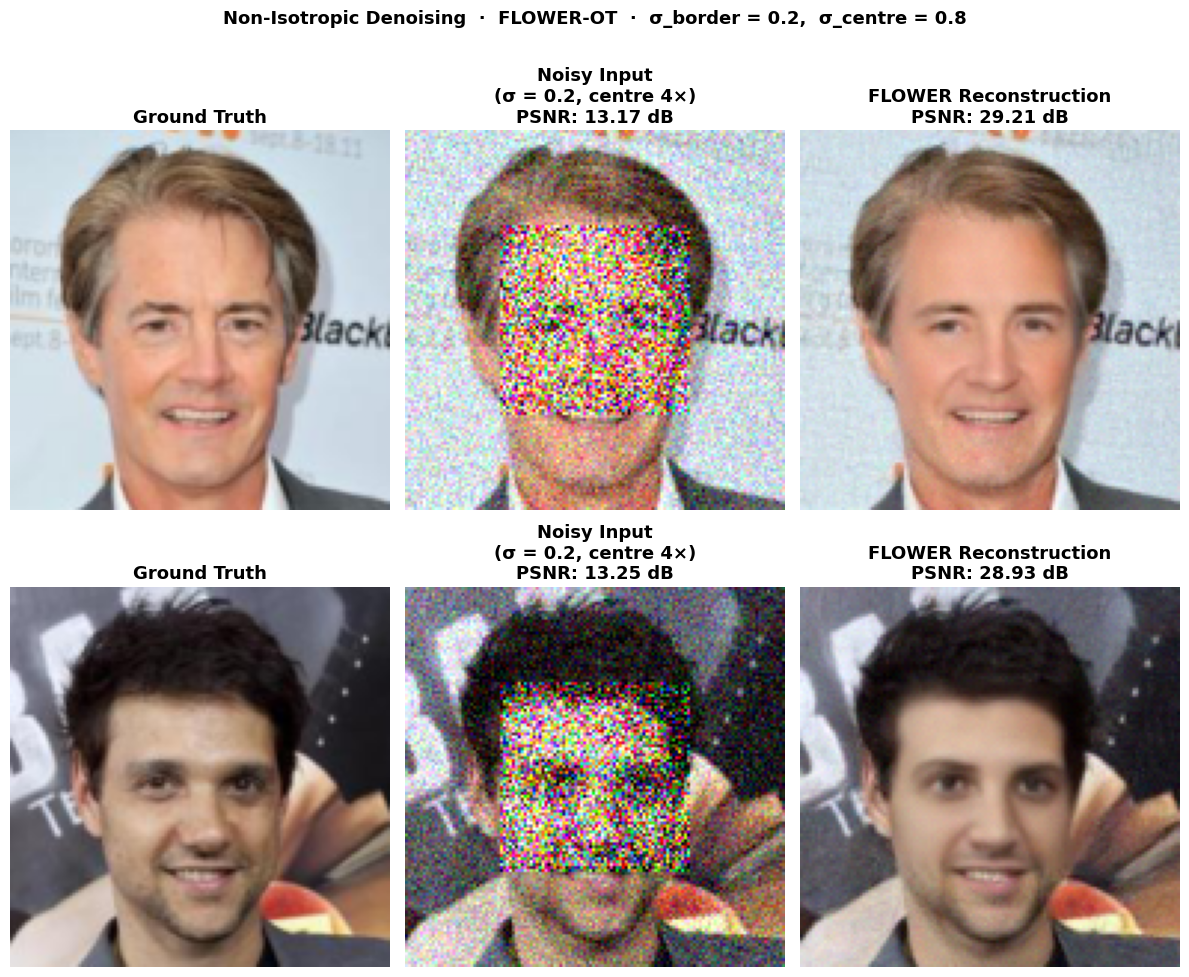

In [6]:
# ── Load Test Images ───────────────────────────────────────────────────────────
# The two CelebA test images (indices 43 and 115) were pre-cropped and resized
# to 128×128 using the same transform as the DataLoader; we apply only the
# normalisation here so the images live in [-1, 1] as the model expects.
load_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),   # maps [0,1] → [-1,1]
])

image_files = [
    os.path.join(ROOT, 'flower_demo', 'celeba_test_43.png'),
    os.path.join(ROOT, 'flower_demo', 'celeba_test_115.png'),
]

ground_truths = []
for path in image_files:
    img = Image.open(path).convert('RGB')
    ground_truths.append(load_transform(img).unsqueeze(0).to(device))


# ── FLOWER Reconstruction — Non-Isotropic Denoising ───────────────────────────
# Algorithm (same flow-matching posterior sampler as CS-MRI, adapted for
# spatially-varying noise):
#   For t = 0 → 1  (in `steps` increments δ):
#     1. Denoised estimate:   x̂₀ = x + (1-t)·v(x,t)
#     2. CG data-consistency:
#            x* = argmin_z  ‖(y - Hz)‖²_R⁻¹ + ‖z - x̂₀‖²/λ
#        with λ = σ_r²(t) and the R-weighted norm accounting for non-iso noise
#     3. Stochastic interpolant update:
#            x_{t+δ} = (t+δ)·x* + (1 - t - δ)·ε,   ε ~ N(0,I)

steps = 20
delta = 1.0 / steps

results = []   # stores (gt, noisy, restored) for each image

for img_idx, gt in enumerate(ground_truths):

    # Simulate non-isotropic noisy observation
    y = H(gt) \
        + sigma_noise * 4 * torch.randn_like(gt) * mask1 \
        + sigma_noise     * torch.randn_like(gt) * (1 - mask1)

    # Initialise from pure Gaussian noise  (t = 0)
    x    = torch.randn_like(gt)
    ones = torch.ones(len(x), device=device)

    # Reverse-diffusion loop
    for it in range(steps):
        t       = delta * it

        # Regularisation noise level at time t
        sigma_r = (1 - t) / np.sqrt(t ** 2 + (1 - t) ** 2)

        # Step 1 — one-step denoised estimate
        x_hat_1 = x + (1 - t) * model_forward(x, ones * t)

        # Step 2 — data-consistency via CG (R-weighted least squares)
        lam     = sigma_r ** 2
        b       = Ht(y / R) + x_hat_1 / lam
        x_star, _ = cg(b, x_hat_1, lam, max_iter=50, eps=1e-5,
                        H=H, Ht=Ht, R=R)

        # Step 3 — stochastic interpolant update
        z0                = torch.randn_like(x)
        estimated_iso_cov = 1 - t - delta
        x = (t + delta) * x_star + estimated_iso_cov * z0

        print(f'\rImage {img_idx + 1}/{len(ground_truths)}  |  '
              f'Step {it + 1:2d}/{steps}  |  t = {t:.3f}',
              end='', flush=True)

    results.append((gt.detach().clone(), y.detach().clone(), x.detach().clone()))
    print()

print('Reconstruction complete.')


# ── Visualise Results ─────────────────────────────────────────────────────────

def to_numpy_img(t):
    """Undo Normalize(0.5, 0.5) and convert CHW tensor → HWC numpy in [0,1]."""
    t = t.squeeze(0).detach().cpu().float()
    t = (t * 0.5 + 0.5).clamp(0, 1)   # [-1,1] → [0,1]
    return t.permute(1, 2, 0).numpy()


col_titles = ['Ground Truth',
              f'Noisy Input\n(σ = {sigma_noise}, centre 4×)',
              'FLOWER Reconstruction']

fig, axes = plt.subplots(len(results), 3, figsize=(12, 5 * len(results)))
if len(results) == 1:
    axes = axes[np.newaxis, :]

for row_idx, (gt, noisy, rec) in enumerate(results):
    psnr_noisy = utils.compute_psnr_func(gt, noisy, cfg)
    psnr_rec   = utils.compute_psnr_func(gt, rec,   cfg)

    imgs  = [to_numpy_img(gt), to_numpy_img(noisy), to_numpy_img(rec)]
    psnrs = [None, psnr_noisy, psnr_rec]

    for col_idx, (ax, img, psnr) in enumerate(zip(axes[row_idx], imgs, psnrs)):
        ax.imshow(img)
        ax.axis('off')
        title = col_titles[col_idx]
        if psnr is not None:
            title += f'\nPSNR: {psnr:.2f} dB'
        ax.set_title(title, fontsize=13, fontweight='bold')

fig.suptitle(
    f'Non-Isotropic Denoising  ·  FLOWER-OT  ·  σ_border = {sigma_noise},  σ_centre = {4 * sigma_noise}',
    fontsize=13, fontweight='bold', y=1.01
)
plt.tight_layout()

out_path = os.path.join(ROOT, 'flower_demo', 'flower_non_iso_results.png')
plt.show()